# Dynamics Introduction

@[Chaoming Wang](mailto:adaduo@outlook.com)

> What I cannot create, I do not understand.   --- Richard Feynman

Brain is a complex dynamical system. In order to simulate it, we provide [brainpy.DynamicalSystem](../apis/simulation/generated/brainpy.simulation.brainobjects.DynamicalSystem.rst). ``brainpy.DynamicalSystem`` can be used to define any brain objects which have dynamics. Various children classes are implemented to model these brain elements, such like: [brainpy.Channel](../apis/simulation/generated/brainpy.simulation.brainobjects.Channel.rst) for neuron channels, [brainpy.NeuGroup](../apis/simulation/generated/brainpy.simulation.brainobjects.NeuGroup.rst) for neuron groups, [brainpy.TwoEndConn](../apis/simulation/generated/brainpy.simulation.brainobjects.TwoEndConn.rst) for synaptic connections, [brainpy.Network](../apis/simulation/generated/brainpy.simulation.brainobjects.Network.rst) for networks, etc. Arbitrary composition of these objects is also an instance of ``brainpy.DynamicalSystem``. Therefore, ``brainpy.DynamicalSystem`` is the universal language to define dynamical models in BrainPy. 

In [1]:
import brainpy as bp
import brainpy.math as bm

## ``brainpy.DynamicalSystem``

In this section, let's try to understand the mechanism and the function of ``brainpy.DynamicalSystem``. 

### What is DynamicalSystem?

First, *what can be defined as DynamicalSystem?*

Intuitively, a `dynamical system` is a system which has the time-dependent state. 

Mathematically, it can be expressed as

$$
\dot{X} = f(X, t)
$$

where $X$ is the state of the system, $t$ is the time, and $f$ is a function describes the time dependence of the system state. 

Alternatively, the evolution of the system along the time can be given by

$$
X(t+dt) = F\left(X(t), t, dt\right)
$$

where $dt$ is the time step, and $F$ is the evolution rule to update the system's state.

Accordingly, in BrainPy, any subclass of ``brainpy.DynamicalSystem`` must implement this updating rule in the *update* function (``def update(self, _t, _dt)``). One dynamical system may have multiple updating rules, therefore, users can define multiple *update* functions. All updating functions are wrapped into an inner data structure **self.steps** (a Python dictionary specifies the *name* and the *function* of updating rules). Let's take a look.

In [2]:
class FitzHughNagumoModel(bp.DynamicalSystem):
    def __init__(self, a=0.8, b=0.7, tau=12.5, **kwargs):
        super(FitzHughNagumoModel, self).__init__(**kwargs)
        
        # parameters
        self.a = a
        self.b = b
        self.tau = tau
        
        # variables
        self.v = bm.Variable([0.])
        self.w = bm.Variable([0.])
        self.I = bm.Variable([0.])
        
    def update(self, _t, _dt):
        # _t : the current time, the system keyword 
        # _dt : the time step, the system keyword 
        
        self.w += (self.v + self.a - self.b * self.w) / self.tau * _dt
        self.v += (self.v - self.v ** 3 / 3 - self.w + self.I) * _dt
        self.I[:] = 0.

Here, we have defined a dynamical system called [FitzHugh–Nagumo neuron model](https://en.wikipedia.org/wiki/FitzHugh%E2%80%93Nagumo_model), whose dynamics is given by: 

$$
{\dot {v}}=v-{\frac {v^{3}}{3}}-w+I, \\
\tau {\dot {w}}=v+a-bw.
$$

By using the [Euler method](../apis/integrators/generated/brainpy.integrators.ode.explicit_rk.Euler.rst), this system can be updated by the following rule:

$$
\begin{aligned}
v(t+dt) &= v(t) + [v(t)-{v(t)^{3}/3}-w(t)+RI] * dt, \\
w(t + dt) &= w(t) + [v(t) + a - b w(t)] * dt.
\end{aligned}
$$

We can inspect all update functions in the model by ``xxx.steps``. 

In [3]:
fnh = FitzHughNagumoModel()

fnh.steps  # all update functions

{'update': <bound method FitzHughNagumoModel.update of <__main__.FitzHughNagumoModel object at 0x7f7f4c7ceaf0>>}

### Why to use DynamicalSystem?

So, *why should I define my dynamical system as brainpy.DynamicalSystem?*

There are several benefits. 

- ``brainpy.DynamicalSystem`` has a systematic naming system. 

First, every instance of ``DynamicalSystem`` has its unique name.

In [4]:
fnh.name  # name for "fnh" instance

'FitzHughNagumoModel0'

In [5]:
# every instance has its unique name

for _ in range(5):
    print(FitzHughNagumoModel().name)

FitzHughNagumoModel1
FitzHughNagumoModel2
FitzHughNagumoModel3
FitzHughNagumoModel4
FitzHughNagumoModel5


In [6]:
# the model name can be specified by yourself

fnh2 = FitzHughNagumoModel(name='X')

fnh2.name

'X'

In [7]:
# same name will cause error

try:
    FitzHughNagumoModel(name='X')
except bp.errors.UniqueNameError as e:
    print(e)

In BrainPy, each object should have a unique name. However, we detect that <__main__.FitzHughNagumoModel object at 0x7f7f4c7f3850> has a used name "X".


Second, variables, children nodes, etc. inside an instance can be easily accessed by the *absolute* or *relative* path. 

In [8]:
# All variables can be acessed by 
# 1). the absolute path

fnh2.vars()

{'X.I': Variable([0.]), 'X.v': Variable([0.]), 'X.w': Variable([0.])}

In [9]:
# 2). or, the relative path

fnh2.vars(method='relative')

{'I': Variable([0.]), 'v': Variable([0.]), 'w': Variable([0.])}

If we wrap many instances into a container: `brainpy.Network`, variables and nodes can also be accessed by absolute or relative path.

In [10]:
fnh_net = bp.Network(f1=fnh, f2=fnh2)

In [11]:
# absolute access of variables

fnh_net.vars()

{'FitzHughNagumoModel0.I': Variable([0.]),
 'FitzHughNagumoModel0.v': Variable([0.]),
 'FitzHughNagumoModel0.w': Variable([0.]),
 'X.I': Variable([0.]),
 'X.v': Variable([0.]),
 'X.w': Variable([0.])}

In [12]:
# relative access of variables

fnh_net.vars(method='relative')

{'f1.I': Variable([0.]),
 'f1.v': Variable([0.]),
 'f1.w': Variable([0.]),
 'f2.I': Variable([0.]),
 'f2.v': Variable([0.]),
 'f2.w': Variable([0.])}

In [13]:
# absolute access of nodes

fnh_net.nodes()

{'FitzHughNagumoModel0': <__main__.FitzHughNagumoModel at 0x7f7f4c7ceaf0>,
 'X': <__main__.FitzHughNagumoModel at 0x7f7f4c7f3700>,
 'Network0': <brainpy.simulation.brainobjects.network.Network at 0x7f7f4c7f3340>}

In [14]:
# relative access of nodes

fnh_net.nodes(method='relative')

{'': <brainpy.simulation.brainobjects.network.Network at 0x7f7f4c7f3340>,
 'f1': <__main__.FitzHughNagumoModel at 0x7f7f4c7ceaf0>,
 'f2': <__main__.FitzHughNagumoModel at 0x7f7f4c7f3700>}

- Automatic monitors. Any instance of ``brainpy.DynamicalSystem`` can call ``.run(duration)``. During running, a [brainpy.Monitor](../apis/simulation/generated/brainpy.simulation.monitor.Monitor.rst) inside the dynamical system (``xxx.mon``) can be used to automatically monitor the history values of the interested variables. Details please see the tutorial of [Monitors and Inputs](../tutorial_simulation/monitors_and_inputs.ipynb).

In [15]:
# in "fnh3" instance, we try to monitor "v", "w", and "I" variables
fnh3 = FitzHughNagumoModel(monitors=['v', 'w', 'I'])

# in "fnh4" instance, we only monitor "v" variable
fnh4 = FitzHughNagumoModel(monitors=['v'], name='Y')

- Convenient input operations. During the model running, users can specify the inputs for each model component, with the format of ``(target, value, [type, operation])`` (the details please see the tutorial of [Monitors and Inputs]).(../tutorial_simulation/monitors_and_inputs.ipynb).
    - The ``target`` is the variable accessed by the *absolute* or *relative* path. *Absolute* path access will be very useful in a huge network model.
    - The default input ``type`` is "fix", means the ``value`` must be a constant scalar or array over time. "iter" type of input is also allowed, which means the ``value`` can be an iterable objects (arrays, or iterable functions, etc.). 
    - The default ``operation`` is ``+``, which means the input ``value`` will be added to the ``target``. Allowed operations include ``+``, ``-``, ``*``, ``/``, and ``=``. 

In [16]:
%matplotlib inline

import matplotlib.pyplot as plt

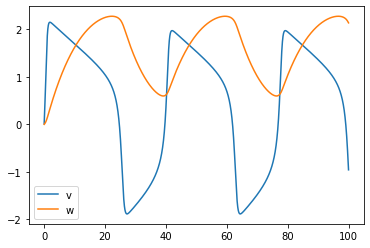

In [17]:
bm.set_dt(dt=0.01)

fnh3.run(duration=100, 
         # relative path to access variable 'I'
         inputs=('I', 1.5))

plt.plot(fnh3.mon.ts, fnh3.mon.v, label='v')
plt.plot(fnh3.mon.ts, fnh3.mon.w, label='w')
plt.legend()

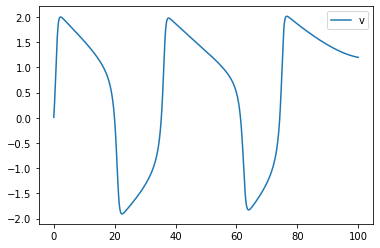

In [18]:
inputs = bm.linspace(1., 2., 10000)

fnh4.run(duration=100, 
         inputs=('Y.I',     #  specify 'target' by the absolute path access
                 inputs,    #  specify 'value' with an iterable array
                 'iter'))   #  "iter" input 'type' must be explicitly specified

plt.plot(fnh4.mon.ts, fnh4.mon.v, label='v')
plt.legend()

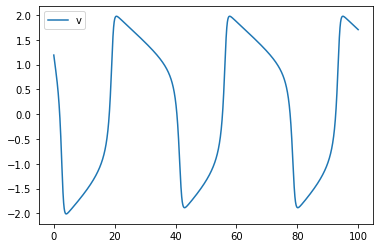

In [19]:
def inputs():
    for i in range(10000): 
        yield 1.5

fnh4.run(duration=100, 
         inputs=('Y.I',     # specify 'target' by the absolute path access
                 inputs(),    # specify 'value' with an iterable function
                 'iter'))   # "iter" input 'type' must be explicitly specified

plt.plot(fnh4.mon.ts, fnh4.mon.v, label='v')
plt.legend()

- ``brainpy.DynamicalSystem`` is a subclass of [brainpy.Base](../apis/generated/brainpy.base.Base.rst), therefore, any instance of ``brainpy.DynamicalSystem`` can be [just-in-time compiled](./jit_compilation.ipynb) into efficient machine codes targeting on CPUs, GPUs, or TPUs. 

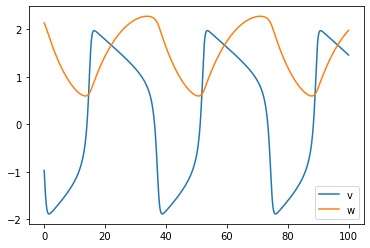

In [20]:
fnh3_jit = bm.jit(fnh3)

fnh3_jit.run(duration=100, inputs=('I', 1.5))

plt.plot(fnh3_jit.mon.ts, fnh3_jit.mon.v, label='v')
plt.plot(fnh3_jit.mon.ts, fnh3_jit.mon.w, label='w')
plt.legend()

- ``brainpy.DynamicalSystem`` can be combined arbitrarily. Any composed system can also benefit from the above convenient interfaces. 

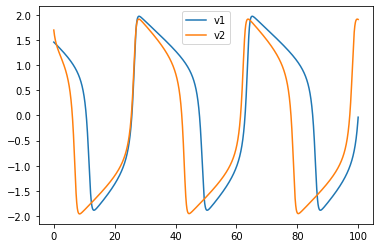

In [21]:
# compose two FitzHughNagumoModel instances into a Network
net2 = bp.Network(f1=fnh3, f2=fnh4, monitors=['f1.v', 'Y.v'])

net2.run(100, inputs=[
    ('f1.I', 1.5), # relative access variable "I" in 'fnh3'
    ('Y.I', 1.0), # absolute access variable "I" in 'fnh4'
])

plt.plot(net2.mon.ts, net2.mon['f1.v'], label='v1')
plt.plot(net2.mon.ts, net2.mon['Y.v'], label='v2')
plt.legend()

In next sections, we will illustrate how to define common brain objects (specifically, the neuron, the synapse and the network) by subclasses of ``brainpy.DynamicalSystem``. 

## ``brainpy.NeuGroup``

`brainpy.NeuGroup` is used for neuron group modeling. User-defined neuron group models should inherit from the `brainpy.NeuGroup`. Let's take the [leaky integrate-and-fire](https://brainmodels.readthedocs.io/en/latest/apis/generated/brainmodels.neurons.LIF.html) (LIF) model as the illustrated example. 

### LIF neuron model

The formal equations of a LIF model is given by:

$$
\begin{aligned}
\tau_m \frac{dV}{dt} = - (V(t) - V_{rest}) + I(t)  \quad\quad (1) \\
\text{after} \, V(t) \gt V_{th}, V(t) =V_{rest} \,
\text{last} \, \tau_{ref} \,  \text{ms}        \quad\quad (2)
\end{aligned}
$$

where $V$ is the membrane potential, $V_{rest}$ is the rest membrane potential, $V_{th}$ is the spike threshold, $\tau_m$ is the time constant, $\tau_{ref}$ is the refractory time period, and $I$ is the time-variant synaptic inputs. 

The above two equations mean that: when the membrane potential $V$ is below $V_{th}$, the model integrates $V$ with the equation (1); once $V > V_{th}$, according to equation (2), we will reset the membrane potential to $V_{rest}$, and the model enters into the refractory period which lasts $\tau_{ref}$ ms. In the refractory period, the membrane potential $V$ will no longer change.  

Let's start to code this LIF neuron model. First, we will define the following items to store the neuron state:

- ``V``: The membrane potential.
- ``input``: The synaptic input.
- ``spike``: Whether produce a spike.
- ``refractory``: Whether the neuron is in the refractory state.
- ``t_last_spike``: To record the last spike time.

Based on these states, the updating logic of LIF model from the current time $t$ to the next time $t+dt$ will be coded as:

In [22]:
class LIF(bp.NeuGroup):
  def __init__(self, size, t_refractory=1., V_rest=0., V_reset=-5.,
               V_th=20., R=1., tau=10., **kwargs):
    super(LIF, self).__init__(size=size, **kwargs)

    # parameters
    self.V_rest = V_rest
    self.V_reset = V_reset
    self.V_th = V_th
    self.R = R
    self.tau = tau
    self.t_refractory = t_refractory

    # variables
    self.V = bm.Variable(bm.random.randn(self.num) * 5. + V_reset)
    self.input = bm.Variable(bm.zeros(self.num))
    self.t_last_spike = bm.Variable(bm.ones(self.num) * -1e7)
    self.refractory = bm.Variable(bm.zeros(self.num, dtype=bool))
    self.spike = bm.Variable(bm.zeros(self.num, dtype=bool))
    
    # functions
    self.integral = bp.odeint(f=self.derivative, method='exponential_euler')

  def derivative(self, V, t, Iext):
    dvdt = (- (V - self.V_rest) + self.R * Iext) / self.tau
    return dvdt

  def update(self, _t, _dt):
    for i in range(self.num):
      if _t - self.t_last_spike[i] <= self.t_refractory:
        self.refractory[i] = True
        self.spike[i] = False
      else:
        V = self.integral(self.V[i], _t, self.input[i])
        if V >= self.V_th:
          self.V[i] = self.V_reset
          self.t_last_spike[i] = _t
          self.spike[i] = True
          self.refractory[i] = True
        else:
          self.V[i] = V
          self.spike[i] = False
          self.refractory[i] = False
      self.input[i] = 0.

That's all, we have coded a LIF neuron model. Note, here we define equation (1) by [brainpy.odeint](../apis/integrators/generated/brainpy.integrators.odeint.rst) as an [ODEIntegrator](../apis/integrators/generated/brainpy.integrators.ODEIntegrator.rst). We will illustrate how to define ODE numerical integration in the [Numerical Solvers for ODEs](../tutorial_intg/ode_numerical_solvers.ipynb) tutorial.

Each NeuGroup has a powerful function: ``.run()``. In this function, it receives the following arguments:

- ``duration``: Specify the simulation duration. It can be a *tuple* with ``(start time, end time)``, or a *int* to specify the duration ``length`` (then the default start time is ``0``).
- ``inputs``: Specify the inputs for each model component. With the format of ``(target, value, [type, operation])``. Details please see the tutorial of [Monitors and Inputs](../tutorial_simulation/monitors_and_inputs.ipynb).
- ``report``: a *float* to specify the progress percent to report. "0" (default) means doesn't report running progress. 

Now, let's run the defined model.

In [23]:
group = LIF(100, monitors=['V'])

Compilation used 0.0004 s.
Start running ...
Run 50.0% used 3.319 s.
Run 100.0% used 6.479 s.
Simulation is done in 6.480 s.



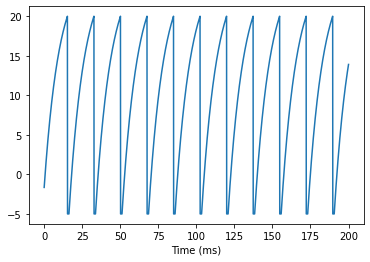

In [24]:
group.run(duration=200., inputs=('input', 26.), report=0.5)
bp.visualize.line_plot(group.mon.ts, group.mon.V, show=True)

Compilation used 0.0003 s.
Start running ...
Run 20.0% used 1.364 s.
Run 40.0% used 2.711 s.
Run 60.0% used 4.024 s.
Run 80.0% used 5.299 s.
Run 100.0% used 6.589 s.
Simulation is done in 6.590 s.



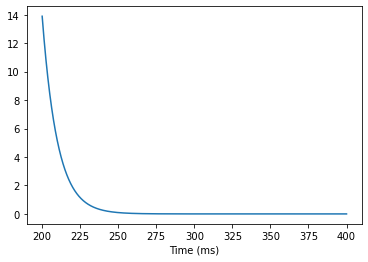

In [25]:
group.run(duration=(200, 400.), report=0.2)
bp.visualize.line_plot(group.mon.ts, group.mon.V, show=True)

In the model definition, BrainPy endows you with the fully data/logic flow control. You can define models with any data you need and any logic you want. There are little limitations/constrains on your customization. 

1. you should "super()" initialize the `brainpy.NeuGroup` with the keyword of the group `size`. 
2. you should define the `update` function.

## ``brainpy.TwoEndConn``

For synaptic computations, BrainPy provides [brainpy.TwoEndConn](../apis/simulation/generated/brainpy.simulation.brainobjects.TwoEndConn.rst) to help you construct the connections between pre-synaptic and post-synaptic neuron groups, and provides [brainpy.connect.TwoEndConnector](../apis/simulation/generated/brainpy.simulation.connect.TwoEndConnector.rst) for synaptic projections between pre- and post-synaptic groups. 

``brainpy.TwoEndConn`` can help to construct **automatic delay** in synaptic computations. The modeling of synapses usually includes a delay time (typically 0.3–0.5 ms) required for a neurotransmitter to be released from a presynaptic membrane, diffuse across the synaptic cleft, and bind to a receptor site on the post-synaptic membrane. BrainPy provides [register_constant_dely()](../apis/simulation/brainobjects.html#brainpy.simulation.brainobjects.DynamicalSystem.register_constant_delay) for automatic state delay. 

``brainpy.connect.TwoEndConnector`` provides convenient interface for **connectivity structure construction**. Various synaptic structures, like *pre_ids*, *post_ids*, *conn_mat*, *pre2post*, *post2pre*, *pre2syn*, *post2syn*, *pre_slice*, and *post_slice* can be constructed. Users just need to **require** such data structures by calling `connector.require('pre_ids', 'post_ids', ...)`. We will detail this function in [Efficient Synaptic Connections](../tutorial_simulation/efficient_synaptic_computation.ipynb).

Here, let's illustrate how to use `brainpy.TwoEndConn` with the [Exponential synapse model](https://brainmodels.readthedocs.io/en/latest/apis/generated/brainmodels.synapses.ExpCOBA.html).

### Exponential synapse model

Exponential synapse model assumes that once a pre-synaptic neuron generates a spike, the synaptic state arises instantaneously, then decays with a certain time constant $\tau_{decay}$. Its dynamics is given by:

$$
\frac{d s}{d t} = -\frac{s}{\tau_{decay}}+\sum_{k} \delta(t-D-t^{k})
$$

where $s$ is the synaptic state, $t^{k}$ is the spike time of the pre-synaptic neuron, and $D$ is the synaptic delay. 

Afterward, the current output onto the post-synaptic neuron is given in the conductance-based form

$$
I_{syn}(t) = g_{max} s \left( V(t)-E \right)
$$

where $E$ is the reversal potential of the synapse, $V$ is the post-synaptic membrane potential, $g_{max}$ is the maximum synaptic conductance. 

So, let's try to implement this synapse model. 

In [26]:
class Exponential(bp.TwoEndConn):
  def __init__(self, pre, post, conn, g_max=1., delay=0., tau=8.0, E=0., **kwargs):
    super(Exponential, self).__init__(pre=pre, post=post, conn=conn, **kwargs)

    # parameters
    self.g_max = g_max
    self.E = E
    self.tau = tau
    self.delay = delay

    # connections
    self.pre_ids, self.post_ids = self.conn.requires('pre_ids', 'post_ids')
    self.num = len(self.pre_ids)
    
    # variables
    self.s = bm.Variable(bm.zeros(self.num))
    self.pre_spike = self.register_constant_delay('ps', size=self.pre.num, delay=delay)
    
    # functions
    self.integral = bp.odeint(self.derivative, method='exponential_euler')

  def derivative(self, s, t):
    dsdt = - s / self.tau
    return dsdt

  def update(self, _t, _dt):
    # P1: push the pre-synaptic spikes into the delay
    self.pre_spike.push(self.pre.spike)
    
    # P2: pull the delayed pre-synaptic spikes
    delayed_pre_spike = self.pre_spike.pull()
    
    # P3: update the synatic state
    self.s[:] = self.integral(self.s, _t)
    
    for syn_i in range(self.num):
      pre_i, post_i = self.pre_ids[syn_i], self.post_ids[syn_i]
    
      # P4: whether pre-synaptic neuron generates a spike
      if delayed_pre_spike[pre_i]:
        self.s[syn_i] += 1.
      
      # P5: output the synapse current onto the post-synaptic neuron
      self.post.input[post_i] += self.g_max * self.s[syn_i] * (self.E - self.post.V[post_i])

Here, we create a synaptic model by using the synaptic structures of *pre_ids* and *post_ids* , looks like this:

<img src="../_static/syn-example-pre_ids-post_ids.png" width="700 px" align="left">

The pre-synaptic neuron index (``pre ids``) is shown in the green color. The post-synaptic neuron index (``post ids``) is shown in the red color. Each pair of *(pre id,  post id)* denotes a synapse between two neuron groups. Each synapse connection also has a unique index, called the *synapse index*, which is shown in the third row (``syn ids``). 

## ``brainpy.Network``

In above, we have illustrated how to define **neurons** by [brainpy.NeuGroup](../apis/simulation/generated/brainpy.simulation.brainobjects.NeuGroup.rst) and **synapses** by [brainpy.TwoEndConn](../apis/simulation/generated/brainpy.simulation.brainobjects.TwoEndConn.rst). In the next, we talk about how to create a network by using [brainpy.Network](../apis/simulation/generated/brainpy.simulation.brainobjects.Network.rst). 

### E/I balanced network

Here, we try to create a [E/I balanced network](https://brainmodels.readthedocs.io/en/latest/examples/EI_nets/Brette_2007_COBA.html) according to the reference [1]. 

This EI network has 4000 leaky integrate-and-fire neurons. Each integrate-and-fire neuron is characterized by a time constant, $\tau$ = 20 ms, and a resting membrane potential, $V_{rest}$ = -60 mV. Whenever the membrane potential crosses a spiking threshold of -50 mV, an action potential is generated and the membrane potential is reset to the resting potential, where it remains clamped for a 5 ms refractory period. 

In [27]:
num_exc = 3200
num_inh = 800

E = LIF(num_exc, tau=20, V_th=-50, V_rest=-60, V_reset=-60, t_refractory=5., monitors=['spike'])
I = LIF(num_inh, tau=20, V_th=-50, V_rest=-60, V_reset=-60, t_refractory=5.)
E.V[:] = bm.random.randn(num_exc) * 5. - 55.
I.V[:] = bm.random.randn(num_inh) * 5. - 55.

The ratio of the excitatory and inhibitory neurons are 4:1. The neurons connect to each other randomly with a connection probability of 2%. 

The kinetics of the synapse is governed by the exponential synapse model shown above. Specifically, synaptic time constants $\tau_e$ = 5 ms for excitatory synapses and $\tau_i$ = 10 ms for inhibitory synapse. The maximum  synaptic conductance is $0.6$ for the excitatory synapse and $6.7$ for the inhibitory synapse. Reversal potentials are $E_e$ = 0 mV and $E_i$ = -80 mV. 

In [28]:
E2E = Exponential(E, E, bp.connect.FixedProb(prob=0.02), E=0., g_max=0.6, tau=5)
E2I = Exponential(E, I, bp.connect.FixedProb(prob=0.02), E=0., g_max=0.6, tau=5)
I2E = Exponential(I, E, bp.connect.FixedProb(prob=0.02), E=-80., g_max=6.7, tau=10)
I2I = Exponential(I, I, bp.connect.FixedProb(prob=0.02), E=-80., g_max=6.7, tau=10)

After this, we can create a network to wrap these object together. 

In [29]:
net = bp.Network(E2E, E2I, I2I, I2E, E=E, I=I)
net = bm.jit(net)

Compilation used 4.8391 s.
Start running ...
Run 10.0% used 1.485 s.
Run 20.0% used 2.806 s.
Run 30.0% used 4.120 s.
Run 40.0% used 5.506 s.
Run 50.0% used 6.886 s.
Run 60.0% used 8.214 s.
Run 70.0% used 9.513 s.
Run 80.0% used 10.834 s.
Run 90.0% used 12.197 s.
Run 100.0% used 13.507 s.
Simulation is done in 13.507 s.



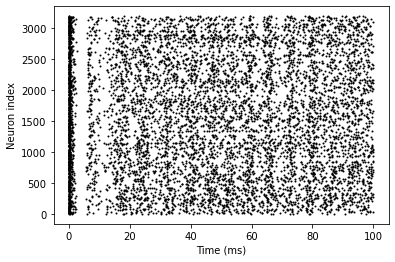

In [30]:
net.run(100., inputs=[('E.input', 20.), ('I.input', 20.)], report=0.1)
bp.visualize.raster_plot(E.mon.ts, E.mon.spike, show=True)

**References**: 

[1] Brette, R., Rudolph, M., Carnevale, T., Hines, M., Beeman, D., Bower, J. M., et al. (2007), Simulation of networks of spiking neurons: a review of tools and strategies., J. Comput. Neurosci., 23, 3, 349–98
